In [8]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

In [9]:
runs = load_runs('../sacred_runs/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))
mis_runs = load_runs('../sacred_mis/')
print("Loaded final runs:", len(mis_runs.keys()))

Loaded runs: 572
Loaded final runs: 364
Loaded final runs: 60


In [10]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 1.0,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## Cartpole
First we start by validating the equivalence with just one policy

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 10, 160, 570, 109, 904
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 10, 570, 904, 160, 109


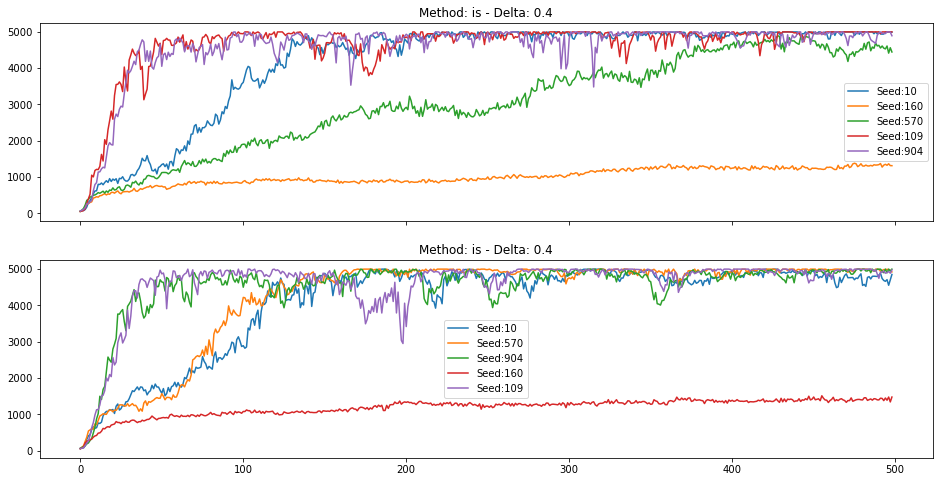

In [11]:
N = 2
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(16,N*4), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2', 0.4), 
                                              ('is', 'max-d2-harmonic', 0.4),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 1
    }
    filtered_runs = filter_runs({**base_query, **query}, mis_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

----------------------------------------
Method: is  - Delta: 0.1
Experiments: 5
Seeds: 904, 570, 160, 10, 109
----------------------------------------
Method: is  - Delta: 0.2
Experiments: 5
Seeds: 570, 10, 904, 109, 160
----------------------------------------
Method: is  - Delta: 0.3
Experiments: 5
Seeds: 109, 570, 160, 904, 10
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 5
Seeds: 109, 570, 10, 160, 904
----------------------------------------
Method: is  - Delta: 0.5
Experiments: 5
Seeds: 10, 109, 570, 904, 160


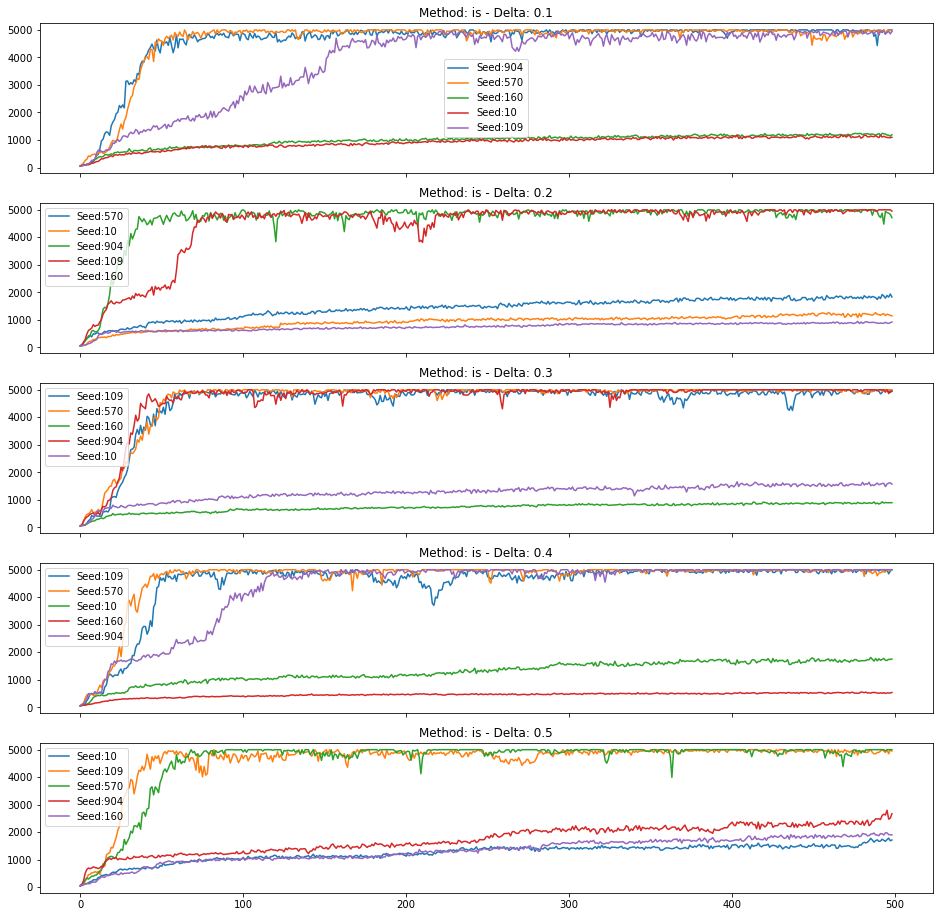

In [13]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.2),
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                            ]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, mis_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

## Inverted double pendulum

In [15]:
fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2-harmonic', 0.1), 
                                              ('is', 'max-d2-harmonic', 0.2),
                                              ('is', 'max-d2-harmonic', 0.3),
                                              ('is', 'max-d2-harmonic', 0.4),
                                              ('is', 'max-d2-harmonic', 0.5),
                                            ]):
    query = {
        'config.env': 'rllab.inverted-double-pendulum,
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 100,
        'config.capacity': 10
    }
    filtered_runs = filter_runs({**base_query, **query}, mis_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

SyntaxError: EOL while scanning string literal (<ipython-input-15-06a213090838>, line 9)